In [23]:
import pandas as pd
import numpy as np
import re
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU
from tensorflow.keras.layers import Dropout
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('bbc_text_cls.csv')

In [ ]:
nltk_data_path = os.path.expanduser("~/nltk_data")
if nltk_data_path not in nltk.data.path:
    nltk.data.path.append(nltk_data_path)


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))



def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) 
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)



df['processed_text'] = df['text'].apply(preprocess_text)
texts = df['processed_text'].values
labels = df['labels'].values
print(df.head())

[nltk_data] Downloading package punkt to /home/perry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/perry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/perry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text    labels  \
0  Ad sales boost Time Warner profit\n\nQuarterly...  business   
1  Dollar gains on Greenspan speech\n\nThe dollar...  business   
2  Yukos unit buyer faces loan claim\n\nThe owner...  business   
3  High fuel prices hit BA's profits\n\nBritish A...  business   
4  Pernod takeover talk lifts Domecq\n\nShares in...  business   

                                      processed_text  
0  ad sale boost time warner profit quarterly pro...  
1  dollar gain greenspan speech dollar hit highes...  
2  yukos unit buyer face loan claim owner embattl...  
3  high fuel price hit ba profit british airway b...  
4  pernod takeover talk lift domecq share uk drin...  


In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
print("Label distribution:")
print(pd.Series(labels).value_counts())


Label distribution:
3    511
0    510
2    417
4    401
1    386
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


max_length = 100  
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [ ]:
history_scratch = None
history_pretrained = None


from tensorflow.keras.layers import Dropout, BatchNormalization

from tensorflow.keras.layers import Dropout
model_scratch = Sequential([
    Embedding(input_dim=vocab_size, output_dim=300, input_length=max_length),
    LSTM(256, return_sequences=False),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(np.unique(y_train)), activation='softmax')
])

model_scratch.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history_scratch = model_scratch.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 342ms/step - accuracy: 0.2668 - loss: 1.5638 - val_accuracy: 0.5618 - val_loss: 1.1004
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 365ms/step - accuracy: 0.6872 - loss: 0.9285 - val_accuracy: 0.7528 - val_loss: 0.7503
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 371ms/step - accuracy: 0.9063 - loss: 0.4416 - val_accuracy: 0.8904 - val_loss: 0.3336
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.9767 - loss: 0.0889 - val_accuracy: 0.9045 - val_loss: 0.2849
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 380ms/step - accuracy: 0.9886 - loss: 0.0668 - val_accuracy: 0.9017 - val_loss: 0.3026
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - accuracy: 0.9951 - loss: 0.0199 - val_accuracy: 0.8315 - val_loss: 0.5176
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 381ms/step - accuracy: 0.9907 - loss: 0.0520 - val_accuracy: 0.8680 - val_loss: 0.3966
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 379ms/step - accuracy: 0.9924 - loss: 0.0254 - val_accu

In [ ]:
embedding_dim = 100
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs


embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [21]:
model_glove = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=max_length, 
              trainable=False),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

model_glove.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history_glove = model_glove.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10


/home/perry/kpi1m/data_analysis/p310/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.5465 - loss: 1.2074 - val_accuracy: 0.5955 - val_loss: 0.9925
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.7812 - loss: 0.5588 - val_accuracy: 0.8989 - val_loss: 0.3149
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.8924 - loss: 0.3345 - val_accuracy: 0.5730 - val_loss: 2.4672
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6875 - loss: 1.2666 - val_accuracy: 0.8624 - val_loss: 0.4348
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8908 - loss: 0.3725 - val_accuracy: 0.9101 - val_loss: 0.2797
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9126 - loss: 0.2893 - val_accuracy: 0.9298 - val_loss: 0.2748
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9522 - loss: 0.1710 - val_accuracy: 0.9185 - val_loss: 0.2948
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9436 - loss: 0.1857 - val_accuracy: 0.9017 - val_loss: 0.

In [22]:
scratch_acc = model_scratch.evaluate(X_test_pad, y_test, verbose=0)[1]
glove_acc = model_glove.evaluate(X_test_pad, y_test, verbose=0)[1]

print(f"Accuracy (Scratch): {scratch_acc:.4f}")
print(f"Accuracy (GloVe): {glove_acc:.4f}")


Accuracy (Scratch): 0.8809
Accuracy (GloVe): 0.8944


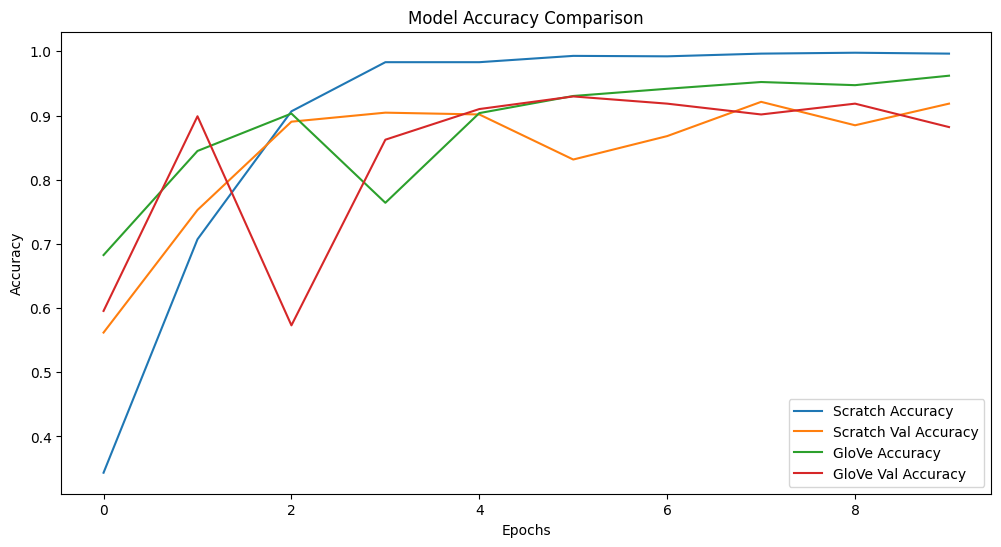

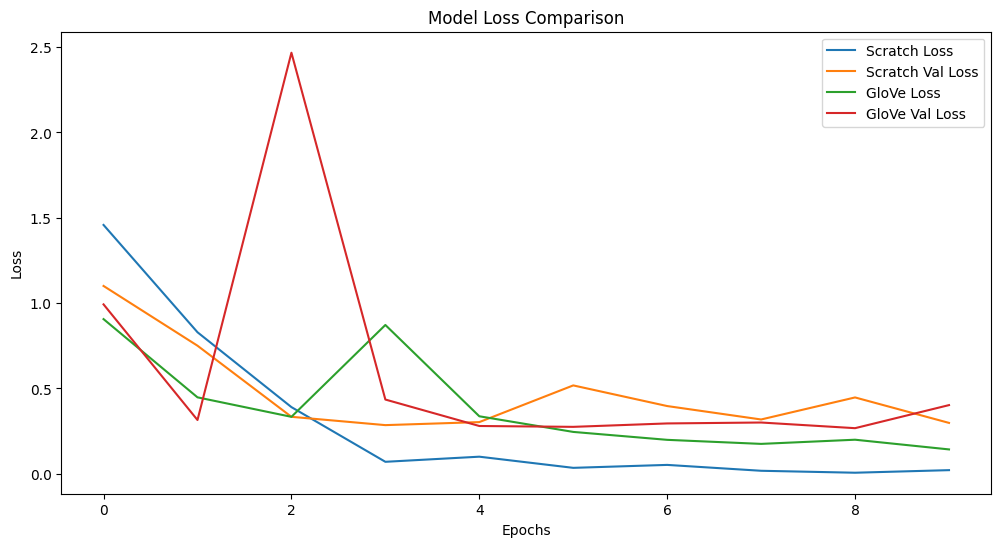

In [25]:
def plot_combined_history(history1, history2, title, metric):
    plt.figure(figsize=(12, 6))
    plt.plot(history1.history[metric], label=f'Scratch {metric.capitalize()}')
    plt.plot(history1.history[f'val_{metric}'], label=f'Scratch Val {metric.capitalize()}')
    plt.plot(history2.history[metric], label=f'GloVe {metric.capitalize()}')
    plt.plot(history2.history[f'val_{metric}'], label=f'GloVe Val {metric.capitalize()}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

plot_combined_history(history_scratch, history_glove, "Model Accuracy Comparison", "accuracy")
plot_combined_history(history_scratch, history_glove, "Model Loss Comparison", "loss")